In [1]:
import os, sys, imp

import keras
import tensorflow as tf

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import datasets as D
imp.reload(D)

import utils as U
imp.reload(U)

import plot_lib as pl
imp.reload(pl)

import numpy as np
import datetime

from timeit import default_timer as timer

pl.set_default()

/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_68002/294708878.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import os, sys, imp


In [2]:
# Constants
MODELDIR = "models"
BATCH_SIZE = 32
EPOCHS = 10

### Load and preprocess images

In [3]:
(X_train, y_train), (X_test, y_test) = D.load_mnist_data()
X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

In [4]:
[n_train, d1, d2] = X_train.shape
x_train = np.reshape(X_train, (n_train, d1*d2)) 

n_test = X_test.shape[0]
x_test = np.reshape(X_test, (n_test, d1*d2))

nc = len(np.unique(y_train)) # number of classes
print(f"num classes: {nc}")

num classes: 10


In [5]:
# Create dataset iterator
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Suhffle and batching
ds_train = ds_train.shuffle(n_train).batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)


### Visualize images

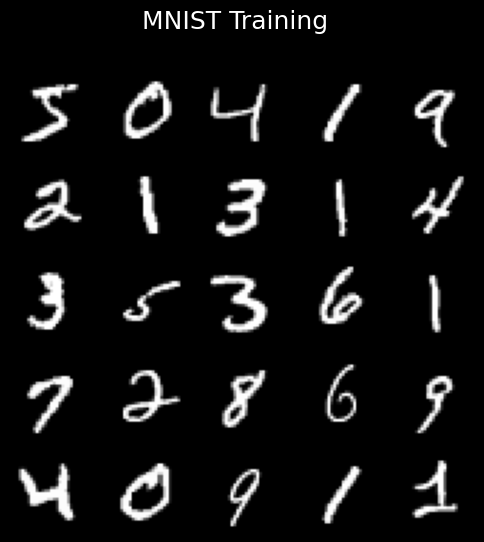

In [6]:
# Visualize training samples
U.visualize_dataset(X_train, title="MNIST Training", n_samples=25)

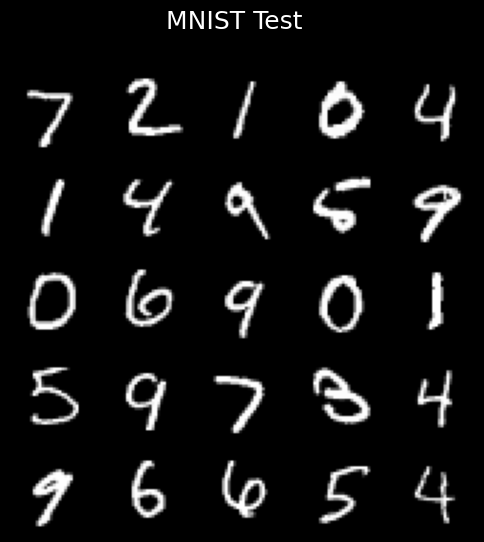

In [7]:
# Visualize test samples
U.visualize_dataset(X_test, title="MNIST Test", n_samples=25)

### Train MLP

Model: "mnist_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


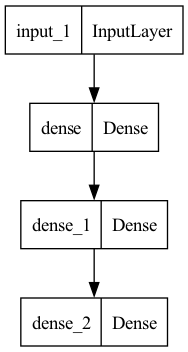

In [8]:
input_shape = (d1*d2,)
inputs = keras.Input(shape=input_shape)
x = keras.layers.Dense(256, activation="relu")(inputs)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(nc)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_mlp")
model.summary()

keras.utils.plot_model(model)

In [9]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.legacy.Adam(learning_rate=1e-4)
accuracy = keras.metrics.SparseCategoricalAccuracy()

In [10]:
# Define callbacks: Tensorboard, Model Checkpoint, Timing
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="./logs/mlp-mnist/" + current_time,
    update_freq="epoch"
)

checkpoint_dir = os.path.join(MODELDIR, f"mlp-mnist-{current_time}")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir, "weights-{epoch:02d}-{val_loss:.2f}.hdf5")
modelcp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_callback = TimingCallback()

In [11]:
# Compile model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[accuracy],
)

In [12]:
# Train model
# history = model.fit(
#     x=x_train,
#     y=y_train, 
#     epochs=EPOCHS, 
#     batch_size=BATCH_SIZE,
#     validation_data=(x_test, y_test),
#     callbacks=[tensorboard_callback, modelcp_callback, timing_callback]
# )

history = model.fit(
    ds_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_data=ds_test,
    callbacks=[tensorboard_callback, modelcp_callback, timing_callback]
)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4560 - sparse_categorical_accuracy: 0.8828 - val_loss: 0.2238 - val_sparse_categorical_accuracy: 0.9360
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1947 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.1590 - val_sparse_categorical_accuracy: 0.9534
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.1300 - val_sparse_categorical_accuracy: 0.9625
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1154 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.1124 - val_sparse_categorical_accuracy: 0.9663
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.1010 - val_sparse_categorical_accuracy: 0.9695
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0800 - spars

In [13]:
# print(timing_callback.logs)
print(f"Elapsed time: {sum(timing_callback.logs):.4f} seconds")

Elapsed time: 24.2061 seconds


In [14]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [15]:
history.history["val_sparse_categorical_accuracy"]

[0.9359999895095825,
 0.9534000158309937,
 0.9624999761581421,
 0.9663000106811523,
 0.9695000052452087,
 0.9722999930381775,
 0.9735000133514404,
 0.9763000011444092,
 0.975600004196167,
 0.9768000245094299]

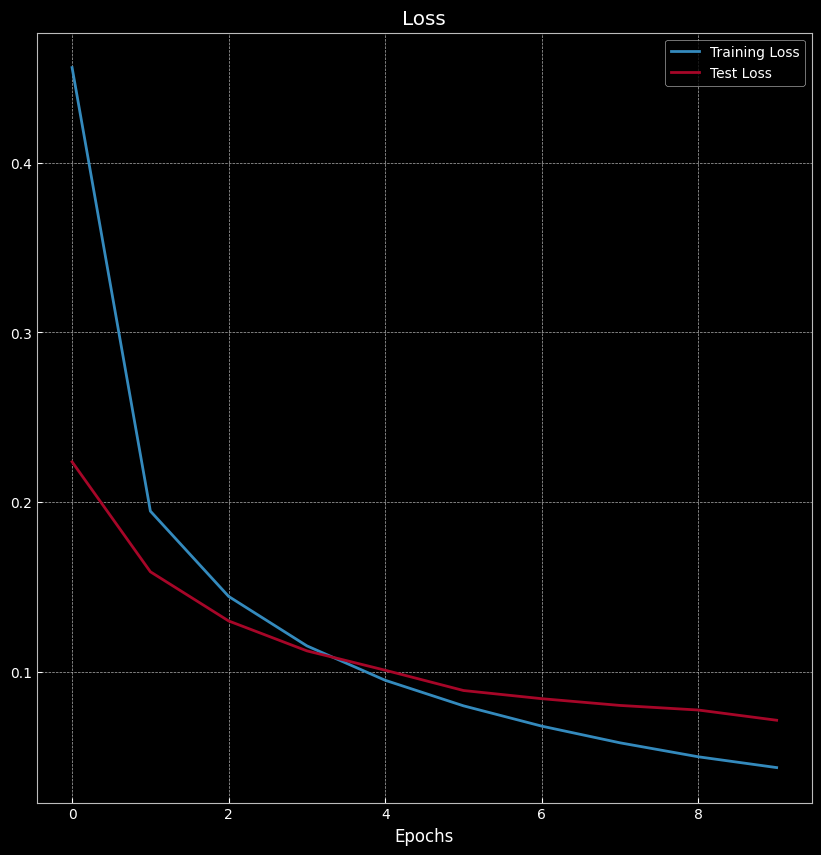

In [16]:
train_loss = history.history["loss"]
test_loss = history.history["val_loss"]
pl.plot_results(
    train_loss,
    test_loss,
    xlabel="Epochs",
    legend=["Training Loss", "Test Loss"],
    title="Loss"
)

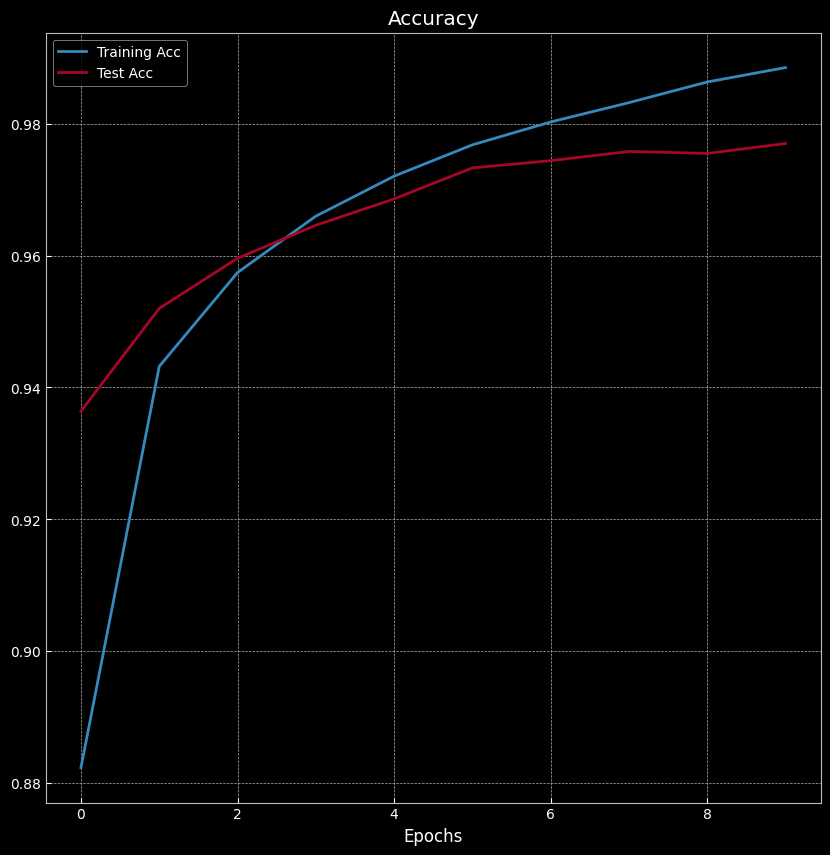

In [17]:
train_acc = history.history["sparse_categorical_accuracy"]
test_acc = history.history["val_sparse_categorical_accuracy"]

pl.plot_results(
    train_acc,
    test_acc,
    xlabel="Epochs",
    legend=["Training Acc", "Test Acc"],
    title="Accuracy"
)